## REMARKS WHEN READING THE PAPER
- Link of the paper: https://science.sciencemag.org/content/sci/362/6419/1140.full.pdf

I wonder how we can create a neural network that can output a variable size vector of probability.
In fact, this NN is predicting 2 things at the same time, for each position:
1. A vector of probabilities associated to the vector of valid moves
2. The value of the game


How can the NN guess the list of valid moves?
### Notes
- Only trained using self-play
- what is the difference between the policy vector P and the search probability pie
we can construct policy vector pie using the value associated to each next valid moves:
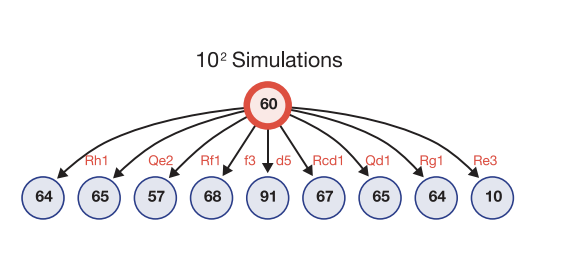
- new updated model used as soon as possible for the remaining steps
- baseline computation speed: 60 000 positions / seconds

- During tournamenet, the best move is found by running the neural network in 6 000 board positions (when stockfish was using 25 000 000)

- what is the difference between the policy vector P and the search probability pie


Cette phrase "AlphaZero÷ does not
augment the training data" veut juste dire: utiliser des parties jouees par des humains dans la vie reelle

## How to encode the actions
The actions are encoded by either
spatial planes or a flat vector.


regardons sur github!!!

From this repository https://github.com/Zeta36/chess-alpha-zero, take a look to this specific method:

```python

def maybe_flip_fen(fen, flip = False):
    if not flip:
        return fen
    foo = fen.split(' ')
    rows = foo[0].split('/')
    def swapcase(a):
        if a.isalpha():
            return a.lower() if a.isupper() else a.upper()
        return a
    def swapall(aa):
        return "".join([swapcase(a) for a in aa])
    return "/".join([swapall(row) for row in reversed(rows)]) \
        + " " + ('w' if foo[1] == 'b' else 'b') \
        + " " + "".join(sorted(swapall(foo[2]))) \
        + " " + foo[3] + " " + foo[4] + " " + foo[5]
def all_input_planes(fen):
    current_aux_planes = aux_planes(fen)

    history_both = to_planes(fen)

    ret = np.vstack((history_both, current_aux_planes))
    assert ret.shape == (18, 8, 8)
    return ret

def canon_input_planes(fen):
    """
    :param fen:
    :return : (18, 8, 8) representation of the game state
    """
    fen = maybe_flip_fen(fen, is_black_turn(fen))
    return all_input_planes(fen)
```

In [19]:
import chess
board = chess.Board()
fen_data = board.fen().split(" ")

In [23]:



fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data


In [37]:
fen #correspond a une position des pieces sur un echiquer

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'

In [42]:
## all the possibilities
one_hot_dictionary = {}
pieces = ['r', "n", "b", "q", 'k', "p"]
possibilities = pieces + [piece.upper() for piece in pieces]
print(len(possibilities))

one_hot_dictionary = {}
one_hot_dictionary["1"] = [0 for _ in range(13)]
for i, possibility in enumerate(possibilities):
    one_hot_dictionary[possibility] = [0 for _ in range(13)]
    one_hot_dictionary[possibility][i] = 1
one_hot_dictionary

12


{'1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'r': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'b': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'q': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'k': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'p': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'B': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]}

In [54]:
import numpy as np



def get_numpy_board(board):
    def transform_line(line):
        result = ""
        for character in line:
            if character.isdigit():
                for i in range(int(character)):
                    result += "1"
            else:
                result += character
        return result
    
    def compute_en_passant(ep_square):
        def alg_to_coord(alg):
            rank = 8 - int(alg[1])        # 0-7
            file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
            return rank, file
        # renvoie une matrice de lataille dun jeu d'echec, contenant True si la case possede un 
        #pion que l'on peut manger en passant
        en_passant = np.zeros((8, 8, 1), dtype=np.bool)
        if ep_square != '-':
            eps = alg_to_coord(foo[3])
            en_passant[eps[0]][eps[1]] = True
        return en_passant

    fen_data = board.fen().split(" ")
    fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
    en_passant = compute_en_passant(ep_square)
    auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                        en_passant]
    
    piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
    for i, line in enumerate(fen.split("/")):
        for j, case in enumerate(transform_line(line)):
            piece_information_plane[i][j] = one_hot_dictionary[case]    
    all_planes = auxiliary_planes + [piece_information_plane]
    all_planes_numpy = np.concatenate(all_planes, axis=-1)
    print(all_planes_numpy.shape) 
    return all_planes_numpy


(8, 8, 18)


In [76]:
def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array

#tout les coups possibles
all_moves = create_uci_labels()
number_moves = len(all_moves)
assert number_moves == 1968
all_planes_numpy = get_numpy_board(board)
shape_board = list(all_planes_numpy.shape)
assert shape_board == [8,8,18]

(8, 8, 18)


In [77]:
all_moves

['a1b1',
 'a1c1',
 'a1d1',
 'a1e1',
 'a1f1',
 'a1g1',
 'a1h1',
 'a1a2',
 'a1a3',
 'a1a4',
 'a1a5',
 'a1a6',
 'a1a7',
 'a1a8',
 'a1b2',
 'a1c3',
 'a1d4',
 'a1e5',
 'a1f6',
 'a1g7',
 'a1h8',
 'a1c2',
 'a1b3',
 'a2b2',
 'a2c2',
 'a2d2',
 'a2e2',
 'a2f2',
 'a2g2',
 'a2h2',
 'a2a1',
 'a2a3',
 'a2a4',
 'a2a5',
 'a2a6',
 'a2a7',
 'a2a8',
 'a2b3',
 'a2c4',
 'a2d5',
 'a2e6',
 'a2f7',
 'a2g8',
 'a2b1',
 'a2c1',
 'a2c3',
 'a2b4',
 'a3b3',
 'a3c3',
 'a3d3',
 'a3e3',
 'a3f3',
 'a3g3',
 'a3h3',
 'a3a1',
 'a3a2',
 'a3a4',
 'a3a5',
 'a3a6',
 'a3a7',
 'a3a8',
 'a3b4',
 'a3c5',
 'a3d6',
 'a3e7',
 'a3f8',
 'a3b2',
 'a3c1',
 'a3b1',
 'a3c2',
 'a3c4',
 'a3b5',
 'a4b4',
 'a4c4',
 'a4d4',
 'a4e4',
 'a4f4',
 'a4g4',
 'a4h4',
 'a4a1',
 'a4a2',
 'a4a3',
 'a4a5',
 'a4a6',
 'a4a7',
 'a4a8',
 'a4b5',
 'a4c6',
 'a4d7',
 'a4e8',
 'a4b3',
 'a4c2',
 'a4d1',
 'a4b2',
 'a4c3',
 'a4c5',
 'a4b6',
 'a5b5',
 'a5c5',
 'a5d5',
 'a5e5',
 'a5f5',
 'a5g5',
 'a5h5',
 'a5a1',
 'a5a2',
 'a5a3',
 'a5a4',
 'a5a6',
 'a5a7',
 'a5a8',
 

## Est ce que j'ai tout les elements pour entrainer mon IA?

- [x] representer la position d'une partie d'echecs sous forme de matrice numpy 
- [x] la liste de tout les coups possibles pour une partie d'echecs (case a to case b etc..)
- [x] connaitre la liste des coups valides pour une position existante (`list(board.legal_moves)`)
- [x] Definition d'un mini modele qui prevoit valeur et une probabilite pour chaque coup (je fais ca maintenant)

In [75]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model

def naive_model_value_and_move_prediction():
    NUMBER_FILTERS = 8
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    print(features.shape)
    features = Flatten()(features)
    value_prediction = Dense(1, activation="sigmoid")(features) #TRY WITH TANGENT FOR output between -1 and 1
    policy_prediction = Dense(number_moves, activation="softmax")(features)

    model = Model(board, [value_prediction, policy_prediction])
    model.compile(loss=["mean_squared_error", "categorical_crossentropy" ], optimizer="Adam")
    model.summary()
    return model
model = naive_model_value_and_move_prediction()


(None, 8, 8, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8, 8, 18)     0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 8, 8, 8)      1304        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 2)      146         conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 128)          0           conv2d_5[0][0]                   
____________________________________________________________________________

In [ ]:
def mcts_search(root_position, model):
    